In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import os
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_blobs # split a dataset into train and test sets
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%ls /content/drive/MyDrive/'ECE496 Capstone Project'/'Data Augmentation'/Data/hifi_maps/

In [ ]:
lofi_folder="/content/drive/MyDrive/ECE496 Capstone Project/Data Augmentation/Data/lofi_maps"
hifi_folder="/content/drive/MyDrive/ECE496 Capstone Project/Data Augmentation/Data/hifi_maps"

hifi_maps = os.listdir(hifi_folder)
lofi_maps = os.listdir(lofi_folder)

In [ ]:
# extract transmitter location from filename
def get_transmitter(filename):
    filename = filename.split('.')[0]
    trans = filename.split('_')[1:]

    for i in range(3):
        trans[i] = trans[i].replace('x','')
        trans[i] = trans[i].replace('y','')
        trans[i] = trans[i].replace('z','')
        trans[i] = trans[i].replace('n','-')
        trans[i] = trans[i].replace('p','.')
        trans[i] = float(trans[i])

    return trans

In [ ]:
print(get_transmitter(lofi_maps[221]))

[-20.7083, 22.7484, 2.75]


In [ ]:
# Display the RSSI Power Map at a given location
def show_map(map, trans_loc):
    # affix size of plot
    plt.rcParams["figure.figsize"] = [5.0, 5.0]
    plt.rcParams["figure.autolayout"] = True
    overlap = 1.0

    # power map
    x_rec = map[:,0]
    y_rec = map[:,1]
    map_rssi = map[:,3]
    receivers = plt.scatter(x_rec,y_rec,c=map_rssi,alpha=overlap)
    cbar = plt.colorbar()
    cbar.set_label("Power [dBm]",rotation=270)

    # transmitter
    transmitter = plt.scatter(trans_loc[0],trans_loc[1],c='red',alpha=overlap)

    plt.show()

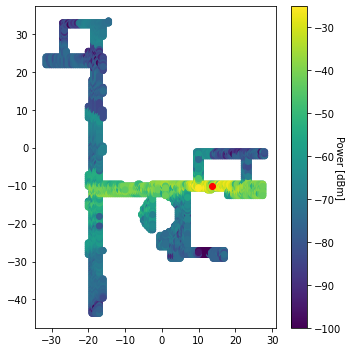

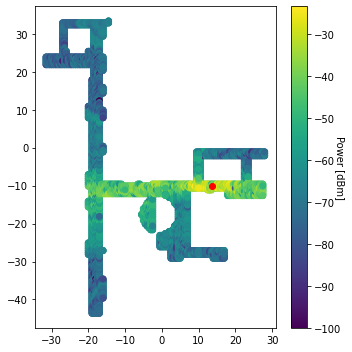

In [ ]:
hifi_idx = 100
trans_loc = get_transmitter(hifi_maps[hifi_idx])

lofi_idx = 0
for idx in range(len(lofi_maps)):
    if get_transmitter(lofi_maps[idx]) == trans_loc:
        lofi_idx = idx
        break

path = lofi_folder+"/"+lofi_maps[lofi_idx]
mapLo = pd.read_csv(path)
mapLo = torch.Tensor(mapLo.to_numpy())
mapLo = mapLo[:,:4]
mapLo[mapLo < -100] = -100
show_map(mapLo,get_transmitter(lofi_maps[lofi_idx]))


path = hifi_folder+"/"+hifi_maps[hifi_idx]
mapHi = pd.read_csv(path)
mapHi = torch.Tensor(mapHi.to_numpy())
mapHi = mapHi[:,:4]
mapHi[mapHi < -100] = -100
show_map(mapHi,get_transmitter(hifi_maps[hifi_idx]))

In [ ]:
print(mapLo[0])
print(mapLo[0][0])

print(mapLo.shape[0])
print(mapLo.shape[1])
print(mapLo)

tensor([ -9.5375, -11.6158,   1.1450, -39.4620])
tensor(-9.5375)
6696
4
tensor([[ -9.5375, -11.6158,   1.1450, -39.4620],
        [ -9.5375, -10.1158,   1.1450, -42.6460],
        [ -9.5375, -12.1158,   1.1450, -39.8310],
        ...,
        [  9.9625,  -3.1158,   1.6450, -74.9350],
        [  9.9625,  -5.6158,   1.6450, -62.3580],
        [  9.9625, -27.6158,   1.6450, -95.3410]])


In [ ]:
# Zoning
def zoning_input(map):
  zone1, zone2, zone3, zone4, zone5, zone6 = [], [] ,[] ,[] ,[] ,[]

# Zoning
  for i in range(map.shape[0]):
    x_coord = float(map[i][0])
    y_coord = float(map[i][1])
    if x_coord >= -20.4998 and x_coord <= -15.3289 and y_coord >= -44.3658 and y_coord <= 21.2484:
      zone1.append(map[i].numpy())
      continue
    if x_coord >= -16.4840 and x_coord <= 27.9773 and y_coord >= -13.1881 and y_coord <= -9.01437:
      zone2.append(map[i].numpy())
      continue
    if x_coord >= -5.69007 and x_coord <= 7.30628 and y_coord >= -26.4982 and y_coord <= -13.1881:
      zone3.append(map[i].numpy())
      continue
    if x_coord >= -31.7083 and x_coord <= -13.9235 and y_coord >= 21.2484 and y_coord <= 33.7773:
      zone4.append(map[i].numpy())
      continue
    if x_coord >= 9.06907 and x_coord <= 28.5555 and y_coord >= -9.01437 and y_coord <= -0.991953:
      zone5.append(map[i].numpy())
      continue
    if x_coord >= 2.02737 and x_coord <= 17.2359 and y_coord >= -29.5907 and y_coord <= -26.7465:
      zone6.append(map[i].numpy())
      continue

  return zone1, zone2, zone3, zone4, zone5, zone6

[array([-20.0375,   8.3842,   1.145 , -58.31  ], dtype=float32), array([-20.0375,   8.8842,   1.145 , -59.415 ], dtype=float32), array([-20.0375,   9.3842,   1.145 , -63.766 ], dtype=float32), array([-20.0375,   9.8842,   1.145 , -62.917 ], dtype=float32), array([-20.0375,  10.3842,   1.145 , -63.249 ], dtype=float32), array([-20.0375,  10.8842,   1.145 , -78.085 ], dtype=float32), array([-20.0375,  -7.1158,   1.145 , -56.163 ], dtype=float32), array([-20.0375, -25.1158,   1.145 , -62.333 ], dtype=float32), array([-20.0375, -15.1158,   1.145 , -49.024 ], dtype=float32), array([-20.0375, -10.1158,   1.145 , -49.563 ], dtype=float32), array([-20.0375, -27.6158,   1.145 , -63.562 ], dtype=float32), array([-20.0375, -27.1158,   1.145 , -63.44  ], dtype=float32), array([-20.0375, -26.6158,   1.145 , -60.823 ], dtype=float32), array([-20.0375, -26.1158,   1.145 , -63.455 ], dtype=float32), array([-20.0375, -25.6158,   1.145 , -60.135 ], dtype=float32), array([-20.0375,  -9.6158,   1.145 , -5

In [ ]:
temp = tf.zeros([128,128]).numpy()
#temp[1] = 1
print("temp: ", temp)
for i in range(mapLo.shape[0]) :
  for j in range(mapLo.shape[1]):
      x_new = (mapLo[i][0] - 0.3125) / 0.625 + 65
      y_new = (mapLo[i][1] - 0.3125) / 0.625 + 75
      #print("x_new: ", int(x_new))
      #print("y_new: ", int(y_new))
      x_new = int(x_new)
      y_new = int(y_new)
      #print(int(mapLo[i][3]))
      temp[x_new][y_new] = int(mapLo[i][3])
print("new temp", temp)

temp:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
new temp [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Normalizing the RSSI values
for i in range(low_fi_data.shape[0]):
  for j in range(low_fi_data.shape[1]):
        if low_fi_data[i][j][2] < -250 :
            low_fi_data[i][j][2] = -250
        low_fi_data[i][j][2] = (low_fi_data[i][j][2] + 250) / 250
        # To match the RGB color scale
        low_fi_data[i][j][2] = (low_fi_data[i][j][2]) * 255


In [ ]:
# Normalizing the RSSI values
for i in range(high_fi_data.shape[0]):
  for j in range(high_fi_data.shape[1]):
        if high_fi_data[i][j][2] < -250 :
            high_fi_data[i][j][2] = -250
        high_fi_data[i][j][2] = (high_fi_data[i][j][2] + 250) / 250
        # To match the RGB color scale
        high_fi_data[i][j][2] = (high_fi_data[i][j][2]) * 255

In [ ]:
# Converting physical coordinates to integers between 0 and 127
for i in range(low_fi_data.shape[0]):
  for j in range(low_fi_data.shape[1]):
        # Changing the x-coord
        low_fi_data[i][j][0] = (low_fi_data[i][j][0] - 0.3125)/0.625 + 55
        # Changing the y-coord
        low_fi_data[i][j][1] = (low_fi_data[i][j][1] - 0.3125)/0.625 + 55

In [ ]:
# Converting physical coordinates to integers between 0 and 127
for i in range(high_fi_data.shape[0]):
  for j in range(high_fi_data.shape[1]):
        # Changing the x-coord
        high_fi_data[i][j][0] = (high_fi_data[i][j][0] - 0.3125)/0.625 + 55
        # Changing the y-coord
        high_fi_data[i][j][1] = (high_fi_data[i][j][1] - 0.3125)/0.625 + 55

In [ ]:
print(low_fi_data[0][0])

[117.284     111.963552  466.8868236]


In [ ]:
#tf.keras.utils.normalize(x,axis=-1,order=2)

In [ ]:
# CNN architecture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.pool = nn.MaxPool2d(2, 2)
        self.unpool = nn.MaxUnpool(2, 2)
        self.conv1 = nn.Conv2d(3, 30, 5)
        self.conv2 = nn.Conv2d(30, 40, 5)
        self.conv3 = nn.Conv2d(40, 50, 3)
    
        self.convT3 = nn.ConvTranspose2D(50, 40 , 3)
        self.convT2 = nn.ConvTranspose2D(40, 30 , 5)
        self.convT1 = nn.ConvTranspose2D(30, 3 , 5)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.unpool(F.relu(self.convT3(x)))
        x = self.unpool(F.relu(self.convT2(x)))
        x = self.unpool(F.relu(self.convT1(x)))

        return x

In [ ]:
# Training module

